# Notebook 27 - Gold Standard Enrichment

**Objectif** : Générer le jeu de données « gold standard » sur la micromobilité française en enrichissant
les 46 k stations GBFS auditées (hors anomalies A1-A6) selon 4 axes :

| Module | Axe | Nouvelles colonnes |
|--------|-----|-------------------|
| 1 | Comblement des zones blanches OSM | `source`, `osm_node_id` |
| 2 | Topographie nationale (MNT / Open-Elevation) | `elevation_m`, `topography_roughness_index` |
| 3A | Continuité cyclable (OSM cycleways) | `infra_cyclable_km`, `infra_cyclable_pct` |
| 3B | Sécurité BAAC accidents cyclistes | `baac_accidents_cyclistes` |
| 4 | Multimodalité lourde (GTFS) | `gtfs_heavy_stops_300m`, `gtfs_stops_within_300m_pct` |

**Volume** : ~46 k stations → stratégie **batch + async + cache** pour tous les appels API externes.

**Source principale** : `data/gbfs_france/stations_all.csv` (pipeline Notebook 20)  
**Sortie** : `output/27_Gold_Standard_Enrichment/tables_csv/stations_gold_standard.parquet`

---
*Auteur : Pipeline de recherche BikeShare-ICT - Cesi 2025-2026*

## 0 · Imports & Configuration

In [29]:
# ── Standard library ──────────────────────────────────────────────────────────
import asyncio
import json
import math
import os
import time
import warnings
import zipfile
from io import StringIO
from pathlib import Path
from typing import Any

# ── Data science ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ── Geospatial ────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, box
from shapely.ops import unary_union

# ── HTTP / async ──────────────────────────────────────────────────────────────
import aiohttp
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ── Progress & logging ────────────────────────────────────────────────────────
from tqdm.auto import tqdm
from tqdm.asyncio import tqdm_asyncio

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 40)
pd.set_option("display.float_format", "{:.4f}".format)

In [30]:
# ── Paths (convention projet) ─────────────────────────────────────────────────
ROOT   = Path("../..")                                  # racine du dépôt
NB20   = ROOT / "output" / "20_GBFS_France_Collecte"   # stations GBFS brutes
NB21   = ROOT / "output" / "21_Classement_Villes_Mobilite_Douce"
OUTPUT = ROOT / "output" / "27_Gold_Standard_Enrichment"
CACHE  = ROOT / "notebooks" / "03_Urban_Spatial" / "cache" / "27"
GBFS_DIR = ROOT / "data" / "gbfs_france"

for d in [OUTPUT / "figures", OUTPUT / "tables_csv", CACHE]:
    d.mkdir(parents=True, exist_ok=True)

# ── API / traitement ──────────────────────────────────────────────────────────
BUFFER_M       = 300       # rayon buffer station (mètres)
ELEVATION_RADIUS_M = 500   # rayon pour le calcul de rugosité topographique
ASYNC_CONCURRENCY  = 10    # nb de requêtes async simultanées (respecter rate limits)
BATCH_SIZE         = 100   # stations par batch pour les APIs synchrones
REQUEST_TIMEOUT    = 15    # timeout HTTP (secondes)

# User-Agent académique (idem NB20)
HEADERS = {"User-Agent": "BikeShare-ICT-Research/1.0 (academic)"}

# CRS de travail
CRS_GEO  = "EPSG:4326"    # WGS-84 (lat/lon)
CRS_PROJ = "EPSG:2154"    # Lambert-93 (métrique France)

print(f"[OK] Répertoires créés.")
print(f"     OUTPUT : {OUTPUT.resolve()}")
print(f"     CACHE  : {CACHE.resolve()}")

[OK] Répertoires créés.
     OUTPUT : C:\Users\Rohan\OneDrive - Cesi\Bureau\CESI\BikeShare-Graph-Forecasting\output\27_Gold_Standard_Enrichment
     CACHE  : C:\Users\Rohan\OneDrive - Cesi\Bureau\CESI\BikeShare-Graph-Forecasting\notebooks\03_Urban_Spatial\cache\27


## 0.1 · Utilitaires transverses

In [31]:
# ── Session HTTP robuste (retry + backoff) ────────────────────────────────────
def make_session(retries: int = 3, backoff: float = 1.0) -> requests.Session:
    """Crée une session requests avec retry exponentiel."""
    session = requests.Session()
    retry = Retry(
        total=retries,
        backoff_factor=backoff,
        status_forcelist=[429, 500, 502, 503, 504],
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    session.headers.update(HEADERS)
    return session

SESSION = make_session()


# ── Sérialisation JSON étendue (numpy scalars) ────────────────────────────────
def _json_default(obj: Any) -> Any:
    """Convertit les types numpy/pandas en types Python natifs pour json.dump."""
    if hasattr(obj, "item"):          # numpy scalar (int64, float64, bool_, …)
        return obj.item()
    if hasattr(obj, "tolist"):        # numpy array
        return obj.tolist()
    raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")


# ── Cache JSON générique ──────────────────────────────────────────────────────
def cache_load(key: str) -> Any | None:
    """Charge un résultat mis en cache depuis CACHE/<key>.json.

    Supprime silencieusement les fichiers corrompus (écriture partielle
    après interruption) et retourne None pour forcer un re-fetch.
    """
    path = CACHE / f"{key}.json"
    if not path.exists():
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except (json.JSONDecodeError, ValueError):
        # Fichier tronqué ou corrompu → on le supprime et on re-fetch
        path.unlink(missing_ok=True)
        return None


def cache_save(key: str, data: Any) -> None:
    """Sauvegarde data dans CACHE/<key>.json de manière atomique.

    - Écriture dans un .tmp puis renommage → pas de fichier corrompu en cas
      d'interruption.
    - Utilise _json_default pour sérialiser les types numpy/pandas.
    """
    path     = CACHE / f"{key}.json"
    tmp_path = CACHE / f"{key}.json.tmp"
    with open(tmp_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, default=_json_default)
    tmp_path.replace(path)   # renommage atomique


# ── Checkpointing DataFrame ───────────────────────────────────────────────────
def checkpoint_save(df: pd.DataFrame, name: str) -> None:
    """Sauvegarde un DataFrame intermédiaire en Parquet dans CACHE."""
    df.to_parquet(CACHE / f"{name}.parquet", index=False)


def checkpoint_load(name: str) -> pd.DataFrame | None:
    """Charge un checkpoint Parquet ou None si inexistant."""
    path = CACHE / f"{name}.parquet"
    return pd.read_parquet(path) if path.exists() else None


print("[OK] Utilitaires chargés.")

[OK] Utilitaires chargés.


## 0.2 · Chargement des stations GBFS auditées (base gold)

In [32]:
# ── Chargement ────────────────────────────────────────────────────────────────
df_stations = pd.read_csv(
    GBFS_DIR / "stations_all.csv",
    low_memory=False,
    encoding="utf-8-sig",
)

print(f"Stations brutes chargées : {len(df_stations):,}")
print(f"Colonnes : {list(df_stations.columns)}")

# ── Nettoyage minimal ─────────────────────────────────────────────────────────
# Supprimer les lignes sans coordonnées valides (anomalies A1-A2 déjà filtrées
# dans NB20, mais on s'en assure ici)
df_stations = df_stations.dropna(subset=["lat", "lon"])
df_stations = df_stations[
    df_stations["lat"].between(41.0, 51.5) &
    df_stations["lon"].between(-5.5, 9.5)
].copy()

# Ajouter un identifiant unique stable
df_stations["uid"] = df_stations["system_id"] + "__" + df_stations["station_id"].astype(str)

# Flag source par défaut
if "source" not in df_stations.columns:
    df_stations["source"] = "GBFS"

print(f"Stations après filtrage géographique : {len(df_stations):,}")

# ── Conversion GeoDataFrame ───────────────────────────────────────────────────
gdf = gpd.GeoDataFrame(
    df_stations,
    geometry=gpd.points_from_xy(df_stations["lon"], df_stations["lat"]),
    crs=CRS_GEO,
)
gdf_proj = gdf.to_crs(CRS_PROJ)   # version métrique pour les buffers

print(f"GeoDataFrame prêt : {gdf.shape}  |  CRS : {gdf.crs}")

Stations brutes chargées : 46,371
Colonnes : ['system_id', 'city', 'system_name', 'region', 'source', 'station_id', 'station_name', 'lat', 'lon', 'capacity', 'has_kiosk', 'address', 'post_code', 'region_id', 'rental_methods', 'n_stations_system', 'si_url', 'fetched_at']
Stations après filtrage géographique : 46,311
GeoDataFrame prêt : (46311, 20)  |  CRS : EPSG:4326


---
## Module 1 · Comblement des Zones Blanches via OSM (Overpass API)

In [33]:
# ── Constantes Overpass ───────────────────────────────────────────────────────
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

# Systèmes identifiés comme « zones blanches » (réseau physique sans flux GBFS)
# Source : audit NB20 + connaissance terrain
ZONES_BLANCHES: list[dict] = [
    # Format : {"city": str, "system_name": str, "bbox": (south, west, north, east)}
    {"city": "Strasbourg",  "system_name": "Vélhop",       "bbox": (48.527, 7.670, 48.625, 7.815)},
    {"city": "Metz",        "system_name": "Metz à Vélo",  "bbox": (49.090, 6.130, 49.165, 6.210)},
    {"city": "Rouen",       "system_name": "cy'clic",      "bbox": (49.390, 1.025, 49.470, 1.145)},
    # ↑ Compléter cette liste après requête au registre transport.data.gouv.fr
    # Appel : curl 'https://transport.data.gouv.fr/api/datasets?type=bike-sharing'
    # puis comparer system_ids manquants dans stations_all.csv
]

# Seuil de distance pour dé-doublonner vs stations GBFS existantes (mètres)
DEDUP_DIST_M = 50


def build_overpass_query(bbox: tuple[float, float, float, float]) -> str:
    """
    Construit une requête Overpass QL pour récupérer tous les nœuds
    et ways avec amenity=bicycle_rental dans une bounding box.

    Parameters
    ----------
    bbox : (south, west, north, east)  - en degrés WGS-84

    Returns
    -------
    str : requête Overpass QL prête à l'envoi
    """
    s, w, n, e = bbox
    return f"""
    [out:json][timeout:30];
    (
      node["amenity"="bicycle_rental"]({s},{w},{n},{e});
      way["amenity"="bicycle_rental"]({s},{w},{n},{e});
    );
    out center tags;
    """


def fetch_osm_bicycle_rental(
    city_meta: dict,
    session: requests.Session | None = None,
) -> list[dict]:
    """
    Interroge l'API Overpass pour les stations amenity=bicycle_rental
    d'une agglomération et retourne une liste de dicts normalisés.

    Parameters
    ----------
    city_meta : dict avec clés 'city', 'system_name', 'bbox'
    session   : session requests (optionnel, créée si None)

    Returns
    -------
    list[dict] : stations OSM au format compatible stations_all.csv
    """
    if session is None:
        session = make_session()

    cache_key = f"osm_{city_meta['city'].lower().replace(' ', '_')}"
    cached = cache_load(cache_key)
    if cached is not None:
        return cached

    query = build_overpass_query(city_meta["bbox"])
    try:
        resp = session.post(
            OVERPASS_URL,
            data={"data": query},
            timeout=REQUEST_TIMEOUT,
        )
        resp.raise_for_status()
        elements = resp.json().get("elements", [])
    except Exception as exc:
        print(f"  [WARN] Overpass echec pour {city_meta['city']}: {exc}")
        return []

    stations = []
    for el in elements:
        # Nœud → lat/lon directs ; Way → centroïde via `center`
        lat = el.get("lat") or el.get("center", {}).get("lat")
        lon = el.get("lon") or el.get("center", {}).get("lon")
        if lat is None or lon is None:
            continue
        tags = el.get("tags", {})
        stations.append({
            "system_id"    : f"osm_{city_meta['city'].lower()}",
            "city"         : city_meta["city"],
            "system_name"  : city_meta["system_name"],
            "station_id"   : str(el["id"]),
            "station_name" : tags.get("name", tags.get("ref", f"OSM_{el['id']}")),
            "lat"          : lat,
            "lon"          : lon,
            "capacity"     : pd.to_numeric(tags.get("capacity"), errors="coerce"),
            "source"       : "OSM",
            "osm_node_id"  : el["id"],
        })

    cache_save(cache_key, stations)
    return stations


def dedup_osm_vs_gbfs(
    gdf_new: gpd.GeoDataFrame,
    gdf_existing: gpd.GeoDataFrame,
    dist_m: float = DEDUP_DIST_M,
) -> gpd.GeoDataFrame:
    """
    Supprime de gdf_new les stations qui ont déjà un équivalent dans
    gdf_existing à moins de dist_m mètres (jointure spatiale + seuil).

    Parameters
    ----------
    gdf_new      : stations OSM à intégrer (CRS Lambert-93)
    gdf_existing : stations GBFS existantes (CRS Lambert-93)
    dist_m       : distance de déduplication en mètres

    Returns
    -------
    GeoDataFrame : stations OSM sans doublons géographiques
    """
    if gdf_new.empty:
        return gdf_new

    # Buffer autour des stations existantes
    existing_buf = gdf_existing.copy()
    existing_buf["geometry"] = existing_buf.geometry.buffer(dist_m)

    # Jointure : stations OSM DANS un buffer existant → doublon
    joined = gpd.sjoin(gdf_new, existing_buf[["geometry"]], how="left", predicate="within")
    mask_new = joined["index_right"].isna()

    n_total = len(gdf_new)
    n_new   = mask_new.sum()
    print(f"  [OSM] {n_total} stations trouvées → {n_new} nouvelles (hors doublons GBFS)")

    return gdf_new.loc[joined[mask_new].index].copy()


print("[OK] Module 1 - fonctions définies.")

[OK] Module 1 - fonctions définies.


In [34]:
# ── Exécution Module 1 ────────────────────────────────────────────────────────
osm_rows = []
for city_meta in tqdm(ZONES_BLANCHES, desc="Overpass zones blanches"):
    rows = fetch_osm_bicycle_rental(city_meta, SESSION)
    osm_rows.extend(rows)
    time.sleep(0.5)

if osm_rows:
    df_osm = pd.DataFrame(osm_rows)
    gdf_osm = gpd.GeoDataFrame(
        df_osm,
        geometry=gpd.points_from_xy(df_osm["lon"], df_osm["lat"]),
        crs=CRS_GEO,
    ).to_crs(CRS_PROJ)

    gdf_osm_clean = dedup_osm_vs_gbfs(gdf_osm, gdf_proj)

    # Harmoniser les colonnes manquantes avant concaténation
    for col in gdf_proj.columns:
        if col not in gdf_osm_clean.columns:
            gdf_osm_clean[col] = np.nan

    gdf_proj = pd.concat(
        [gdf_proj, gdf_osm_clean[gdf_proj.columns]],
        ignore_index=True,
    )

    # ── Déduplication : sjoin peut dupliquer un point OSM si son index
    # apparaît plusieurs fois dans la jointure (point proche de N stations)
    n_before = len(gdf_proj)
    gdf_proj = gdf_proj.drop_duplicates(subset=["uid"]).reset_index(drop=True)
    if len(gdf_proj) < n_before:
        print(f"  [M1] {n_before - len(gdf_proj)} uid dupliqués supprimés")

    gdf_proj = gpd.GeoDataFrame(gdf_proj, crs=CRS_PROJ)
    print(f"[M1] Total stations après enrichissement OSM : {len(gdf_proj):,}")
else:
    print("[M1] Aucune zone blanche configurée ou aucune station OSM trouvée.")

assert gdf_proj["uid"].duplicated().sum() == 0, "[M1] UIDs non-uniques après Module 1 !"
checkpoint_save(gdf_proj.drop(columns="geometry"), "cp_module1")
print(f"[M1] UIDs uniques : {gdf_proj['uid'].nunique():,} / {len(gdf_proj):,}")

Overpass zones blanches:   0%|          | 0/3 [00:00<?, ?it/s]

  [OSM] 197 stations trouvées → 53 nouvelles (hors doublons GBFS)
  [M1] 52 uid dupliqués supprimés
[M1] Total stations après enrichissement OSM : 46,312
[M1] UIDs uniques : 46,311 / 46,312


---
## Module 2 · Topographie Nationale (Open-Elevation / SRTM)

In [ ]:
# ── API Open-Topo-Data (SRTM 30m, gratuit, no auth, max 100 pts/req, ~1 req/s) ─
# Plus fiable que Open-Elevation : uptime élevé, données SRTM30m sur la France
ELEVATION_API_URL = "https://api.opentopodata.org/v1/srtm30m"
ELEV_BATCH_SIZE   = 100    # maximum 100 points par requête
ELEV_RATE_LIMIT_S = 1.1   # pause entre requêtes (rate limit officiel : 1 req/s)
ELEV_TRI_RADIUS_M = 500   # rayon pour le calcul du TRI via voisins spatiaux


def fetch_elevations_batch(
    coords: list[tuple[float, float]],
    session: requests.Session,
    retries: int = 3,
) -> list[float | None]:
    """
    Interroge Open-Topo-Data pour un batch de coordonnées (lat, lon).
    Réessaie jusqu'à `retries` fois en cas d'erreur temporaire.

    Returns
    -------
    list[float | None] : élévations en mètres, None si erreur persistante
    """
    payload = {"locations": [{"latitude": lat, "longitude": lon} for lat, lon in coords]}
    for attempt in range(retries):
        try:
            resp = session.post(ELEVATION_API_URL, json=payload, timeout=REQUEST_TIMEOUT)
            resp.raise_for_status()
            return [r.get("elevation") for r in resp.json().get("results", [])]
        except Exception as exc:
            if attempt < retries - 1:
                time.sleep(2 ** attempt)
            else:
                print(f"  [WARN] Élévation batch échoué ({len(coords)} pts) : {exc}")
                return [None] * len(coords)


def compute_elevations_all(
    gdf: gpd.GeoDataFrame,
    session: requests.Session | None = None,
    batch_size: int = ELEV_BATCH_SIZE,
    rate_limit_s: float = ELEV_RATE_LIMIT_S,
) -> list[float | None]:
    """
    Calcule l'élévation pour toutes les stations via Open-Topo-Data.
    Requêtes synchrones avec rate limiting (~1 req/s, ≈ 8 min pour 46 k stations).

    Parameters
    ----------
    gdf          : GeoDataFrame avec géométrie (n'importe quel CRS)
    session      : session requests avec retry
    batch_size   : points par requête (max 100 pour Open-Topo-Data)
    rate_limit_s : délai entre requêtes en secondes

    Returns
    -------
    list[float | None] : élévations dans le même ordre que gdf
    """
    if session is None:
        session = make_session()

    gdf_wgs = gdf.to_crs(CRS_GEO) if gdf.crs.to_epsg() != 4326 else gdf
    coords  = list(zip(gdf_wgs.geometry.y, gdf_wgs.geometry.x))

    elevations: list[float | None] = []
    batches = [coords[i : i + batch_size] for i in range(0, len(coords), batch_size)]
    n_batches = len(batches)
    eta_min = math.ceil(n_batches * rate_limit_s / 60)
    print(f"  {n_batches} requêtes × {rate_limit_s}s ≈ {eta_min} min")

    for batch in tqdm(batches, desc="Élévation (Open-Topo-Data)"):
        elevations.extend(fetch_elevations_batch(batch, session))
        time.sleep(rate_limit_s)

    return elevations


def compute_tri_from_neighbors(
    gdf: gpd.GeoDataFrame,
    elevations: list[float | None],
    radius_m: float = ELEV_TRI_RADIUS_M,
) -> list[float | None]:
    """
    Calcule le Terrain Roughness Index (TRI) pour chaque station
    à partir des élévations des stations voisines dans un rayon radius_m.

    Méthode : pour chaque station, on collecte les élévations de toutes
    les autres stations situées à ≤ radius_m, puis on calcule l'écart-type
    des dénivelés absolus entre la station centrale et ses voisines.
    Avantage : 0 appel API supplémentaire (réutilise les élévations déjà calculées).

    Returns
    -------
    list[float | None] : TRI en mètres, None si < 2 voisins avec données
    """
    gdf_e = gdf[["uid", "geometry"]].copy()
    gdf_e["_elev"] = elevations

    # Buffers de recherche
    buffers = gdf_e.copy()
    buffers["geometry"] = buffers.geometry.buffer(radius_m)

    joined = gpd.sjoin(
        gdf_e.rename(columns={"uid": "uid_n", "_elev": "elev_n"}),
        buffers[["uid", "geometry", "_elev"]].rename(columns={"_elev": "elev_c"}),
        how="inner",
        predicate="within",
    )
    # Exclure la station elle-même
    joined = joined[joined["uid_n"] != joined["uid"]]

    tri_map: dict[str, float | None] = {}
    for uid_c, grp in joined.groupby("uid"):
        elev_c = grp["elev_c"].iloc[0]
        if pd.isna(elev_c):
            tri_map[uid_c] = None
            continue
        diffs = (grp["elev_n"] - elev_c).abs().dropna()
        tri_map[uid_c] = float(diffs.std()) if len(diffs) >= 2 else None

    return [tri_map.get(uid) for uid in gdf["uid"]]


print("[OK] Module 2 - fonctions définies (Open-Topo-Data, sync, TRI par voisins).")


In [ ]:
# ── Exécution Module 2 ────────────────────────────────────────────────────────
cp_elev = checkpoint_load("cp_module2_elev")
COVERAGE_THRESHOLD = 0.90   # relancer si < 90 % des stations ont une élévation

if cp_elev is not None and "elevation_m" in cp_elev.columns:
    n_valid = int(cp_elev["elevation_m"].notna().sum())
    pct     = n_valid / len(gdf_proj)
    if pct < COVERAGE_THRESHOLD:
        print(f"[M2] Checkpoint incomplet ({n_valid:,}/{len(gdf_proj):,} = {pct:.1%}) → recalcul.")
        cp_elev = None
    else:
        print(f"[M2] Checkpoint OK ({n_valid:,}/{len(gdf_proj):,}) - chargement depuis le cache.")
        gdf_proj["elevation_m"]                = cp_elev["elevation_m"].values
        gdf_proj["topography_roughness_index"] = cp_elev["topography_roughness_index"].values

if cp_elev is None:
    sess = make_session()
    print(f"[M2] Calcul élévation pour {len(gdf_proj):,} stations (synchrone)…")

    elevations = compute_elevations_all(gdf_proj, sess)
    gdf_proj["elevation_m"] = elevations

    print("[M2] Calcul TRI via voisins spatiaux…")
    tri_values = compute_tri_from_neighbors(gdf_proj, elevations)
    gdf_proj["topography_roughness_index"] = tri_values

    checkpoint_save(
        gdf_proj[["uid", "elevation_m", "topography_roughness_index"]],
        "cp_module2_elev",
    )

print(f"[M2] elevation_m        - valides : {gdf_proj['elevation_m'].notna().sum():,}")
print(f"[M2] roughness_index    - valides : {gdf_proj['topography_roughness_index'].notna().sum():,}")
gdf_proj[["elevation_m", "topography_roughness_index"]].describe()


---
## Module 3A · Continuité Cyclable (OSM Cycleways)

In [37]:
import random
from shapely.geometry import LineString

# ── Filtres OSM pour les aménagements cyclables sécurisés ─────────────────────
# Seules les infrastructures en site propre ou protégées sont comptabilisées.
CYCLEWAY_FILTERS = {
    "highway": ["cycleway"],
    "cycleway": ["track", "lane", "opposite_track", "shared_lane"],
    "bicycle": ["designated"],
}

# Endpoints Overpass alternatifs (rotation en cas de 429/504)
OVERPASS_ENDPOINTS = [
    "https://overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
    "https://maps.mail.ru/osm/tools/overpass/api/interpreter",
]


def _bbox_from_stations(
    gdf_city: gpd.GeoDataFrame,
    margin_deg: float = 0.02,
) -> tuple[float, float, float, float]:
    """
    Calcule la bounding box (south, west, north, east) en WGS-84
    depuis les coordonnées des stations d'une ville, avec une marge.
    Plus fiable que la recherche par nom OSM.
    """
    wgs = gdf_city.to_crs(CRS_GEO)
    return (
        wgs.geometry.y.min() - margin_deg,   # south
        wgs.geometry.x.min() - margin_deg,   # west
        wgs.geometry.y.max() + margin_deg,   # north
        wgs.geometry.x.max() + margin_deg,   # east
    )


def fetch_cycleways_for_city(
    city_name: str,
    bbox: tuple[float, float, float, float],
    max_retries: int = 4,
) -> gpd.GeoDataFrame | None:
    """
    Télécharge les aménagements cyclables OSM (site propre) pour une ville
    via l'API Overpass, avec retry exponentiel et rotation d'endpoints.

    Stratégie anti-rate-limit :
      - Retry jusqu'à max_retries fois sur 429 / 504 / 502
      - Backoff exponentiel : 10s → 20s → 40s → 80s
      - Rotation sur OVERPASS_ENDPOINTS à chaque tentative
      - Cache .parquet persistant pour éviter les re-téléchargements

    Parameters
    ----------
    city_name   : nom de la ville (utilisé comme clé de cache uniquement)
    bbox        : (south, west, north, east) en WGS-84, calculé depuis
                  les stations via _bbox_from_stations()
    max_retries : nombre maximum de tentatives

    Returns
    -------
    GeoDataFrame linestrings (CRS Lambert-93) ou None si indisponible
    """
    cache_key  = f"cycleways_{city_name.lower().replace(' ', '_').replace('-', '_')}"
    cache_path = CACHE / f"{cache_key}.parquet"
    if cache_path.exists():
        return gpd.read_parquet(cache_path)

    s, w, n, e = bbox
    # Requête bbox directe : évite le problème area/name et les timeouts
    # sur les grandes agglomérations. Timeout Overpass augmenté à 90s.
    query = f"""
    [out:json][timeout:90];
    (
      way["highway"="cycleway"]({s:.5f},{w:.5f},{n:.5f},{e:.5f});
      way["cycleway"~"track|lane|opposite_track"]({s:.5f},{w:.5f},{n:.5f},{e:.5f});
    );
    out geom;
    """

    elements = None
    for attempt in range(max_retries):
        endpoint = OVERPASS_ENDPOINTS[attempt % len(OVERPASS_ENDPOINTS)]
        try:
            resp = SESSION.post(endpoint, data={"data": query}, timeout=95)

            if resp.status_code == 429:
                wait = 10 * (2 ** attempt) + random.uniform(0, 3)
                print(f"  [429] {city_name} → attente {wait:.0f}s "
                      f"(tentative {attempt + 1}/{max_retries}, endpoint {attempt % len(OVERPASS_ENDPOINTS) + 1})")
                time.sleep(wait)
                continue

            if resp.status_code in (502, 503, 504):
                wait = 15 * (2 ** attempt) + random.uniform(0, 5)
                print(f"  [{resp.status_code}] {city_name} → attente {wait:.0f}s")
                time.sleep(wait)
                continue

            resp.raise_for_status()
            elements = resp.json().get("elements", [])
            break   # succès

        except Exception as exc:
            if attempt < max_retries - 1:
                wait = 10 * (2 ** attempt)
                time.sleep(wait)
            else:
                print(f"  [WARN] Cycleways Overpass échoué pour {city_name} "
                      f"après {max_retries} tentatives: {exc}")

    if not elements:
        return None

    rows = []
    for el in elements:
        geom_pts = el.get("geometry", [])
        if len(geom_pts) < 2:
            continue
        rows.append({
            "osm_id"  : el["id"],
            "geometry": LineString([(p["lon"], p["lat"]) for p in geom_pts]),
        })

    if not rows:
        return None

    gdf_cy = gpd.GeoDataFrame(rows, crs=CRS_GEO).to_crs(CRS_PROJ)
    gdf_cy.to_parquet(cache_path)
    return gdf_cy


def compute_cycleway_metrics(
    gdf_stations: gpd.GeoDataFrame,
    gdf_cycleways: gpd.GeoDataFrame,
    buffer_m: float = BUFFER_M,
) -> pd.DataFrame:
    """
    Pour chaque station, calcule :
      - infra_cyclable_km  : km d'aménagement cyclable dans le buffer
      - infra_cyclable_pct : ratio infra / périmètre du buffer (0-1)

    Parameters
    ----------
    gdf_stations  : GeoDataFrame stations (CRS Lambert-93)
    gdf_cycleways : GeoDataFrame linestrings cyclables (CRS Lambert-93)
    buffer_m      : rayon du buffer en mètres

    Returns
    -------
    DataFrame uid × infra_cyclable_km × infra_cyclable_pct
    """
    buffers = gdf_stations[["uid", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(buffer_m)

    joined = gpd.overlay(buffers, gdf_cycleways, how="intersection", keep_geom_type=False)
    joined["length_m"] = joined.geometry.length
    agg = joined.groupby("uid")["length_m"].sum().reset_index()
    agg.rename(columns={"length_m": "infra_cyclable_m"}, inplace=True)

    result = gdf_stations[["uid"]].merge(agg, on="uid", how="left")
    result["infra_cyclable_m"] = result["infra_cyclable_m"].fillna(0)
    result["infra_cyclable_km"]  = result["infra_cyclable_m"] / 1000

    perimeter = 2 * math.pi * buffer_m
    result["infra_cyclable_pct"] = (result["infra_cyclable_m"] / perimeter).clip(0, 1)

    return result[["uid", "infra_cyclable_km", "infra_cyclable_pct"]]


print("[OK] Module 3A - fonctions définies.")

[OK] Module 3A - fonctions définies.


In [38]:
# ── Exécution Module 3A ───────────────────────────────────────────────────────
# Stratégie nationale : regrouper les stations par ville, calculer la bbox
# depuis leurs coordonnées, et télécharger les cycleways avec retry.
# Cache persistant par ville : si interrompu, les villes déjà traitées
# ne sont pas re-téléchargées.

def _safe_merge(gdf: gpd.GeoDataFrame, df_right: pd.DataFrame,
                on: str, module: str) -> gpd.GeoDataFrame:
    """Merge avec assertion anti-explosion : déduplique df_right et vérifie
    que le nombre de lignes ne change pas après le merge."""
    n_dup = df_right[on].duplicated().sum()
    if n_dup:
        print(f"  [{module}] ⚠ {n_dup} uid dupliqués dans df_right → déduplication")
        df_right = df_right.drop_duplicates(subset=[on])
    n_before = len(gdf)
    gdf = gdf.merge(df_right, on=on, how="left")
    assert len(gdf) == n_before, (
        f"[{module}] EXPLOSION après merge : {n_before:,} → {len(gdf):,} lignes. "
        f"Vérifier les uid dupliqués."
    )
    return gdf

cp_3a = checkpoint_load("cp_module3a")

if cp_3a is not None and "infra_cyclable_km" in cp_3a.columns:
    print("[M3A] Checkpoint global trouvé.")
    gdf_proj = _safe_merge(
        gdf_proj,
        cp_3a[["uid", "infra_cyclable_km", "infra_cyclable_pct"]],
        on="uid", module="M3A",
    )
else:
    cities = gdf_proj["city"].dropna().unique()
    print(f"[M3A] Traitement cycleways pour {len(cities)} villes…")
    print(f"      Délai inter-ville : 3-6 s + backoff 10-80 s sur 429/504")
    print(f"      Endpoints : {len(OVERPASS_ENDPOINTS)} (rotation automatique)")

    cycleway_results = []
    for i, city in enumerate(tqdm(cities, desc="Cycleways par ville")):
        gdf_city = gdf_proj[gdf_proj["city"] == city].copy()

        # Bbox calculé depuis les stations → plus fiable que le nom OSM
        bbox = _bbox_from_stations(gdf_city)

        gdf_cy = fetch_cycleways_for_city(city, bbox=bbox)

        if gdf_cy is None or gdf_cy.empty:
            city_res = pd.DataFrame({
                "uid"               : gdf_city["uid"].drop_duplicates(),
                "infra_cyclable_km" : 0.0,
                "infra_cyclable_pct": 0.0,
            })
        else:
            city_res = compute_cycleway_metrics(gdf_city, gdf_cy)
        cycleway_results.append(city_res)

        # Checkpoint partiel toutes les 10 villes
        if (i + 1) % 10 == 0:
            df_partial = pd.concat(cycleway_results, ignore_index=True)
            checkpoint_save(df_partial, f"cp_module3a_partial_{i + 1}")

        time.sleep(random.uniform(3.0, 6.0))

    df_3a = pd.concat(cycleway_results, ignore_index=True)
    gdf_proj = _safe_merge(gdf_proj, df_3a, on="uid", module="M3A")
    checkpoint_save(df_3a.drop_duplicates(subset=["uid"]), "cp_module3a")

print(f"[M3A] {len(gdf_proj):,} stations | "
      f"infra_cyclable_km médiane : {gdf_proj['infra_cyclable_km'].median():.3f} km")

[M3A] Checkpoint global trouvé.
[M3A] 46,312 stations | infra_cyclable_km médiane : 0.474 km


---
## Module 3B · Sécurité - Accidents Cyclistes (BAAC)

In [39]:
# ── Configuration BAAC ───────────────────────────────────────────────────────
BAAC_DATASET_ID   = "53698f4ca3a729239d2036df"
BAAC_DATASET_API  = f"https://www.data.gouv.fr/api/1/datasets/{BAAC_DATASET_ID}/"
BAAC_YEARS        = [2021, 2022, 2023]
BAAC_CATV_BICYCLE = 1   # code véhicule "Bicyclette" dans la table vehicules (catv=1)

# URLs de secours (fallback si l'API est indisponible) - vérifiées 2026-02
# NOTE : catv (type de véhicule) est dans la table vehicules, pas usagers
BAAC_FALLBACK_URLS: dict[int, dict[str, str]] = {
    2023: {
        "caract"   : "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241028-103125/caract-2023.csv",
        "vehicules": "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241023-153253/vehicules-2023.csv",
    },
    2022: {
        "caract"   : "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-093927/carcteristiques-2022.csv",
        "vehicules": "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/20231005-094147/vehicules-2022.csv",
    },
    2021: {
        "caract"   : "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2020/20221024-113743/carcteristiques-2021.csv",
        "vehicules": "https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2020/20221024-113925/vehicules-2021.csv",
    },
}


def _resolve_baac_urls(
    year: int,
    resources: list[dict],
) -> dict[str, str | None]:
    """
    Recherche dans la liste des ressources data.gouv.fr les URLs
    des fichiers caractéristiques et vehicules pour une année donnée.
    Tolère les variantes de nommage (caract/caracteristiques/carcteristiques).

    Parameters
    ----------
    year      : année BAAC (ex: 2023)
    resources : liste de dicts issus de l'API data.gouv.fr

    Returns
    -------
    dict avec clés 'caract' et 'vehicules' (valeur None si non trouvé)
    """
    year_str = str(year)
    result   = {"caract": None, "vehicules": None}

    for res in resources:
        title    = (res.get("title") or "").lower()
        url      = res.get("url") or ""
        # Restreindre au nom de fichier pour éviter les faux positifs
        # sur le chemin du dataset (ex: annees-de-2005-a-2021)
        filename = url.split("/")[-1].lower() if url else ""
        if year_str not in title and year_str not in filename:
            continue
        if "vehicul" in title and result["vehicules"] is None:
            result["vehicules"] = url
        if any(k in title for k in ["caract", "carcte"]) and result["caract"] is None:
            result["caract"] = url

    return result


def load_baac_cyclists(
    years: list[int] = BAAC_YEARS,
    session: requests.Session | None = None,
) -> gpd.GeoDataFrame:
    """
    Télécharge et fusionne les tables BAAC (caractéristiques + vehicules)
    pour filtrer les accidents impliquant au moins un cycliste (catv == 1).
    Les URLs sont résolues dynamiquement depuis l'API data.gouv.fr
    puis vérifiées contre les URLs de secours en cas d'erreur 404.

    NOTE : catv (category of vehicle) est dans la table vehicules, pas usagers.
           catv == 1 → Bicyclette (code BAAC officiel).

    Colonnes retenues : Num_Acc, lat, lon
    CRS de sortie     : Lambert-93 (EPSG:2154)
    """
    if session is None:
        session = make_session()

    cache_path = CACHE / "baac_cyclists.parquet"
    if cache_path.exists():
        print("  [BAAC] Cache trouvé.")
        return gpd.read_parquet(cache_path)

    # ── Résolution dynamique des URLs ─────────────────────────────────────────
    try:
        resp      = session.get(BAAC_DATASET_API, timeout=15)
        resp.raise_for_status()
        resources = resp.json()["resources"]
        print(f"  [BAAC] Catalogue récupéré : {len(resources)} ressources.")
    except Exception as exc:
        print(f"  [WARN] API data.gouv.fr indisponible ({exc}) - utilisation des URLs de secours.")
        resources = []

    frames_carac, frames_vehic = [], []

    for year in tqdm(years, desc="Téléchargement BAAC"):
        # Résoudre les URLs (API d'abord, fallback ensuite)
        resolved  = _resolve_baac_urls(year, resources)
        fallback  = BAAC_FALLBACK_URLS.get(year, {})

        url_carac = resolved["caract"]    or fallback.get("caract")
        url_vehic = resolved["vehicules"] or fallback.get("vehicules")

        # ── Caractéristiques (lat / long) ─────────────────────────────────────
        if url_carac:
            try:
                r = session.get(url_carac, timeout=30)
                r.raise_for_status()
                df_c = pd.read_csv(
                    StringIO(r.text),
                    sep=";", encoding="utf-8", low_memory=False,
                    usecols=lambda c: c in ["Num_Acc", "lat", "long", "an"],
                )
                frames_carac.append(df_c)
                print(f"  [BAAC] {year} caract    : {len(df_c):,} lignes")
            except Exception as exc:
                print(f"  [WARN] BAAC carac {year} : {exc}")
        else:
            print(f"  [WARN] BAAC carac {year} : URL introuvable")

        # ── Vehicules (catv = type véhicule, catv==1 → Bicyclette) ────────────
        if url_vehic:
            try:
                r = session.get(url_vehic, timeout=30)
                r.raise_for_status()
                df_v = pd.read_csv(
                    StringIO(r.text),
                    sep=";", encoding="utf-8", low_memory=False,
                    usecols=lambda c: c in ["Num_Acc", "catv"],
                )
                frames_vehic.append(df_v)
                print(f"  [BAAC] {year} vehicules : {len(df_v):,} lignes")
            except Exception as exc:
                print(f"  [WARN] BAAC vehicules {year} : {exc}")
        else:
            print(f"  [WARN] BAAC vehicules {year} : URL introuvable")

    if not frames_carac or not frames_vehic:
        print("  [WARN] Aucune donnée BAAC disponible - colonne remplie à NaN.")
        return gpd.GeoDataFrame(columns=["Num_Acc", "geometry"], crs=CRS_PROJ)

    df_carac = pd.concat(frames_carac, ignore_index=True)
    df_vehic = pd.concat(frames_vehic, ignore_index=True)

    # Filtrer les accidents impliquant au moins un véhicule de type bicyclette
    df_vehic["catv"] = pd.to_numeric(df_vehic["catv"], errors="coerce")
    cyclist_accs = df_vehic[
        df_vehic["catv"] == BAAC_CATV_BICYCLE
    ]["Num_Acc"].unique()

    df_acc = df_carac[df_carac["Num_Acc"].isin(cyclist_accs)].copy()
    df_acc = df_acc.rename(columns={"long": "lon"})

    # Normaliser les coordonnées : virgule → point, puis /100000 si > 1000
    for col in ["lat", "lon"]:
        df_acc[col] = pd.to_numeric(
            df_acc[col].astype(str).str.replace(",", ".", regex=False),
            errors="coerce",
        )
        mask = df_acc[col].abs() > 1000
        df_acc.loc[mask, col] = df_acc.loc[mask, col] / 100_000

    df_acc = df_acc.dropna(subset=["lat", "lon"])
    df_acc = df_acc[
        df_acc["lat"].between(41.0, 51.5) &
        df_acc["lon"].between(-5.5, 9.5)
    ]

    gdf_acc = gpd.GeoDataFrame(
        df_acc,
        geometry=gpd.points_from_xy(df_acc["lon"], df_acc["lat"]),
        crs=CRS_GEO,
    ).to_crs(CRS_PROJ)

    gdf_acc.to_parquet(cache_path)
    print(f"  [BAAC] {len(gdf_acc):,} accidents cyclistes géolocalisés et mis en cache.")
    return gdf_acc


def count_accidents_in_buffers(
    gdf_stations: gpd.GeoDataFrame,
    gdf_accidents: gpd.GeoDataFrame,
    buffer_m: float = BUFFER_M,
) -> pd.Series:
    """
    Compte le nombre d'accidents cyclistes dans un buffer de buffer_m mètres
    autour de chaque station via jointure spatiale (R-tree vectorisée).
    """
    buffers = gdf_stations[["uid", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(buffer_m)

    joined = gpd.sjoin(
        gdf_accidents[["geometry"]],
        buffers,
        how="inner",
        predicate="within",
    )
    counts = joined.groupby("uid").size().rename("baac_accidents_cyclistes")
    return gdf_stations["uid"].map(counts).fillna(0).astype(int)


print("[OK] Module 3B - fonctions définies.")


[OK] Module 3B - fonctions définies.


In [40]:
# ── Exécution Module 3B ───────────────────────────────────────────────────────
gdf_accidents = load_baac_cyclists(BAAC_YEARS, SESSION)

if not gdf_accidents.empty:
    gdf_proj["baac_accidents_cyclistes"] = count_accidents_in_buffers(
        gdf_proj, gdf_accidents
    )
else:
    print("[M3B] Données BAAC indisponibles - colonne remplie à NaN.")
    gdf_proj["baac_accidents_cyclistes"] = np.nan

print(f"[M3B] Accidents cyclistes - médiane : {gdf_proj['baac_accidents_cyclistes'].median():.1f}")
print(f"[M3B] Accidents cyclistes - max     : {gdf_proj['baac_accidents_cyclistes'].max():.0f}")
checkpoint_save(
    gdf_proj[["uid", "baac_accidents_cyclistes"]],
    "cp_module3b",
)

  [BAAC] Catalogue récupéré : 106 ressources.


Téléchargement BAAC:   0%|          | 0/3 [00:00<?, ?it/s]

  [BAAC] 2021 caract    : 56,518 lignes
  [BAAC] 2021 vehicules : 97,315 lignes
  [BAAC] 2022 caract    : 55,302 lignes
  [BAAC] 2022 vehicules : 0 lignes
  [BAAC] 2023 caract    : 54,822 lignes
  [BAAC] 2023 vehicules : 0 lignes
  [BAAC] 5,167 accidents cyclistes géolocalisés et mis en cache.
[M3B] Accidents cyclistes - médiane : 1.0
[M3B] Accidents cyclistes - max     : 22


---
## Module 4 · Multimodalité Lourde (GTFS France)

In [41]:
# ── Route types GTFS considérés comme « transport lourd » ────────────────────
# Ref: https://gtfs.org/documentation/schedule/reference/#routestxt
GTFS_HEAVY_ROUTE_TYPES = {
    0: "Tram / Streetcar / Light Rail",
    1: "Subway / Metro",
    2: "Rail (Train)",
    11: "Trolleybus",
    # 3 = Bus standard (exclu sauf BHNS identifié par route_desc)
}

# URL catalogue GTFS France (transport.data.gouv.fr - API publique)
# Retourne les datasets de type « gtfs » actifs
TRANSPORT_DATAGOUV_API = (
    "https://transport.data.gouv.fr/api/datasets"
    "?type=public-transit&page_size=100"
)


def fetch_gtfs_catalog(
    session: requests.Session | None = None,
    max_pages: int = 20,
) -> pd.DataFrame:
    """
    Récupère le catalogue GTFS national depuis transport.data.gouv.fr.
    Retourne un DataFrame avec colonnes : dataset_id, title, download_url.

    Parameters
    ----------
    session   : session requests
    max_pages : nombre max de pages à paginer

    Returns
    -------
    DataFrame du catalogue GTFS
    """
    if session is None:
        session = make_session()

    cache_key = "gtfs_catalog"
    cached = cache_load(cache_key)
    if cached:
        return pd.DataFrame(cached)

    entries = []
    url = TRANSPORT_DATAGOUV_API
    for page in range(max_pages):
        try:
            resp = session.get(url, timeout=REQUEST_TIMEOUT)
            resp.raise_for_status()
            data = resp.json()
        except Exception as exc:
            print(f"  [WARN] Catalog GTFS page {page}: {exc}")
            break

        datasets = data if isinstance(data, list) else data.get("data", [])
        if not datasets:
            break

        for ds in datasets:
            for res in ds.get("resources", []):
                if res.get("format", "").lower() in ["gtfs", "zip"]:
                    entries.append({
                        "dataset_id"   : ds.get("id"),
                        "title"        : ds.get("title"),
                        "download_url" : res.get("url") or res.get("original_url"),
                    })

        next_url = data.get("links", {}).get("next") if isinstance(data, dict) else None
        if not next_url:
            break
        url = next_url

    cache_save(cache_key, entries)
    print(f"  [GTFS] Catalogue : {len(entries)} flux GTFS trouvés.")
    return pd.DataFrame(entries)


def load_gtfs_stops_from_zip(
    gtfs_url: str,
    session: requests.Session | None = None,
) -> pd.DataFrame | None:
    """
    Télécharge une archive GTFS et extrait stops.txt + routes.txt pour
    ne conserver que les arrêts des lignes de transport lourd.

    Parameters
    ----------
    gtfs_url : URL de téléchargement de l'archive GTFS (.zip)
    session  : session requests

    Returns
    -------
    DataFrame avec colonnes stop_id, stop_lat, stop_lon, route_type
    ou None si erreur / pas de transport lourd
    """
    if session is None:
        session = make_session()

    try:
        resp = session.get(gtfs_url, timeout=60, stream=True)
        resp.raise_for_status()
        content = resp.content
    except Exception as exc:
        print(f"    [WARN] GTFS download échoué ({gtfs_url[:60]}…): {exc}")
        return None

    try:
        with zipfile.ZipFile(pd.io.common.BytesIO(content)) as zf:
            names = zf.namelist()

            if "stops.txt" not in names:
                return None

            df_stops = pd.read_csv(zf.open("stops.txt"), low_memory=False)
            df_stops = df_stops.rename(columns={
                "stop_lat": "lat", "stop_lon": "lon"
            })

            # Filter on heavy routes only if routes.txt available
            heavy_stop_ids: set | None = None
            if "routes.txt" in names and "stop_times.txt" in names and "trips.txt" in names:
                df_routes = pd.read_csv(zf.open("routes.txt"), low_memory=False)
                heavy_routes = df_routes[
                    df_routes["route_type"].isin(GTFS_HEAVY_ROUTE_TYPES)
                ]["route_id"]

                df_trips = pd.read_csv(
                    zf.open("trips.txt"),
                    usecols=["route_id", "trip_id"],
                    low_memory=False,
                )
                heavy_trips = df_trips[
                    df_trips["route_id"].isin(heavy_routes)
                ]["trip_id"]

                df_st = pd.read_csv(
                    zf.open("stop_times.txt"),
                    usecols=["trip_id", "stop_id"],
                    low_memory=False,
                )
                heavy_stop_ids = set(
                    df_st[df_st["trip_id"].isin(heavy_trips)]["stop_id"].unique()
                )

            if heavy_stop_ids is not None:
                df_stops = df_stops[df_stops["stop_id"].isin(heavy_stop_ids)]

            return df_stops[["stop_id", "lat", "lon"]].dropna(
                subset=["lat", "lon"]
            )

    except Exception as exc:
        print(f"    [WARN] GTFS parse échoué: {exc}")
        return None


def compute_gtfs_proximity(
    gdf_stations: gpd.GeoDataFrame,
    gdf_stops: gpd.GeoDataFrame,
    buffer_m: float = BUFFER_M,
) -> pd.DataFrame:
    """
    Pour chaque station, calcule :
      - gtfs_heavy_stops_300m     : nb d'arrêts TC lourd dans le buffer
      - gtfs_stops_within_300m_pct : booléen (>0) ou score normalisé

    Parameters
    ----------
    gdf_stations : GeoDataFrame stations (CRS Lambert-93)
    gdf_stops    : GeoDataFrame arrêts GTFS (CRS Lambert-93)
    buffer_m     : rayon buffer en mètres

    Returns
    -------
    DataFrame uid × gtfs_heavy_stops_300m × gtfs_stops_within_300m_pct
    """
    buffers = gdf_stations[["uid", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(buffer_m)

    # Jointure spatiale arrêts dans buffers
    joined = gpd.sjoin(
        gdf_stops[["geometry"]],
        buffers,
        how="inner",
        predicate="within",
    )
    counts = joined.groupby("uid").size().rename("gtfs_heavy_stops_300m")

    result = gdf_stations[["uid"]].copy()
    result["gtfs_heavy_stops_300m"]    = result["uid"].map(counts).fillna(0).astype(int)
    result["gtfs_stops_within_300m_pct"] = (
        result["gtfs_heavy_stops_300m"] > 0
    ).astype(float)

    return result[["uid", "gtfs_heavy_stops_300m", "gtfs_stops_within_300m_pct"]]


print("[OK] Module 4 - fonctions définies.")

[OK] Module 4 - fonctions définies.


In [42]:
# ── Exécution Module 4 ────────────────────────────────────────────────────────
cp_4 = checkpoint_load("cp_module4")

if cp_4 is not None and "gtfs_heavy_stops_300m" in cp_4.columns:
    print("[M4] Checkpoint GTFS trouvé.")
    gdf_proj = _safe_merge(
        gdf_proj,
        cp_4[["uid", "gtfs_heavy_stops_300m", "gtfs_stops_within_300m_pct"]],
        on="uid", module="M4",
    )
else:
    # Etape 4.1 : télécharger le catalogue
    df_catalog = fetch_gtfs_catalog(SESSION)
    print(f"[M4] {len(df_catalog)} flux GTFS dans le catalogue.")

    # Etape 4.2 : télécharger et parser les stops par flux
    all_stops = []
    for _, row in tqdm(df_catalog.iterrows(), total=len(df_catalog), desc="Parsing GTFS"):
        if pd.isna(row["download_url"]):
            continue
        cache_stop_path = CACHE / f"gtfs_stops_{row['dataset_id']}.parquet"
        if cache_stop_path.exists():
            df_s = pd.read_parquet(cache_stop_path)
        else:
            df_s = load_gtfs_stops_from_zip(row["download_url"], SESSION)
            if df_s is not None and not df_s.empty:
                df_s.to_parquet(cache_stop_path)
        if df_s is not None and not df_s.empty:
            all_stops.append(df_s)
        time.sleep(0.3)

    if not all_stops:
        print("[M4] Aucun arrêt GTFS récupéré - colonnes remplies à 0.")
        gdf_proj["gtfs_heavy_stops_300m"]      = 0
        gdf_proj["gtfs_stops_within_300m_pct"] = 0.0
    else:
        # Etape 4.3 : consolider et construire le GeoDataFrame stops
        df_all_stops = (
            pd.concat(all_stops, ignore_index=True)
            .drop_duplicates(subset=["lat", "lon"])
        )
        df_all_stops = df_all_stops[
            df_all_stops["lat"].between(41.0, 51.5) &
            df_all_stops["lon"].between(-5.5, 9.5)
        ]
        gdf_stops = gpd.GeoDataFrame(
            df_all_stops,
            geometry=gpd.points_from_xy(df_all_stops["lon"], df_all_stops["lat"]),
            crs=CRS_GEO,
        ).to_crs(CRS_PROJ)
        print(f"[M4] {len(gdf_stops):,} arrêts TC lourd consolidés.")

        # Etape 4.4 : calcul proximité + merge sécurisé
        df_gtfs_res = compute_gtfs_proximity(gdf_proj, gdf_stops)
        gdf_proj = _safe_merge(gdf_proj, df_gtfs_res, on="uid", module="M4")
        checkpoint_save(df_gtfs_res.drop_duplicates(subset=["uid"]), "cp_module4")

print(f"[M4] {len(gdf_proj):,} stations | "
      f"accès TC lourd : {(gdf_proj['gtfs_heavy_stops_300m'] > 0).sum():,} "
      f"({100*(gdf_proj['gtfs_heavy_stops_300m'] > 0).mean():.1f}%)")

[M4] 587 flux GTFS dans le catalogue.


Parsing GTFS:   0%|          | 0/587 [00:00<?, ?it/s]

    [WARN] GTFS download échoué (https://www.data.gouv.fr/api/1/datasets/r/2f1e1bfc-d378-4e3d…): 401 Client Error: Unauthorized for url: https://download.data.grandlyon.com/files/rdata/tcl_sytral.tcltheorique/GTFS_TCL.ZIP
    [WARN] GTFS download échoué (https://www.data.gouv.fr/api/1/datasets/r/c9e5dd3f-8eed-4ad7…): 403 Client Error: Forbidden for url: https://media.ilevia.fr/opendata/gtfs.zip
    [WARN] GTFS download échoué (https://www.data.gouv.fr/api/1/datasets/r/ee10c41a-e8fb-49b9…): 404 Client Error: Not Found for url: https://data.metropole-dijon.fr/api/explore/v2.1/catalog/datasets/zones-a-faibles-emissions-mobilite/exports/shp
    [WARN] GTFS download échoué (https://www.data.gouv.fr/api/1/datasets/r/d6c75600-f730-421e…): HTTPSConnectionPool(host='exs.sud.cityway.fr', port=443): Max retries exceeded with url: /gtfs.aspx?key=SUD&amp;operatorCode=ORANGE (Caused by ResponseError('too many 500 error responses'))
    [WARN] GTFS download échoué (https://www.data.gouv.fr/api/1/data

---
## 5 · Validation & Export du Gold Standard

In [ ]:
# ── Rapport de complétude ─────────────────────────────────────────────────────
NEW_COLS = [
    "elevation_m",
    "topography_roughness_index",
    "infra_cyclable_km",
    "infra_cyclable_pct",
    "baac_accidents_cyclistes",
    "gtfs_heavy_stops_300m",
    "gtfs_stops_within_300m_pct",
]

src_counts = gdf_proj["source"].value_counts(dropna=False)
n_osm  = (gdf_proj["source"] == "OSM").sum()
n_orig = len(gdf_proj) - n_osm   # stations GBFS originales (toutes sources sauf OSM)

print("=" * 60)
print("RAPPORT DE COMPLÉTUDE - GOLD STANDARD")
print("=" * 60)
print(f"Stations totales  : {len(gdf_proj):,}")
print(f"  Sources GBFS    : {n_orig:,}  (MobilityData + Manuel)")
print(f"  Sources OSM M1  : {n_osm:,}")
print()
print("Répartition 'source' :")
for src, cnt in src_counts.items():
    print(f"  {str(src):<20} {cnt:>7,}")
print()
for col in NEW_COLS:
    if col in gdf_proj.columns:
        n_valid   = gdf_proj[col].notna().sum()
        pct_valid = 100 * n_valid / len(gdf_proj)
        print(f"  {col:<38} {n_valid:>7,} valides ({pct_valid:5.1f}%)")
    else:
        print(f"  {col:<38} ── MANQUANT")
print("=" * 60)


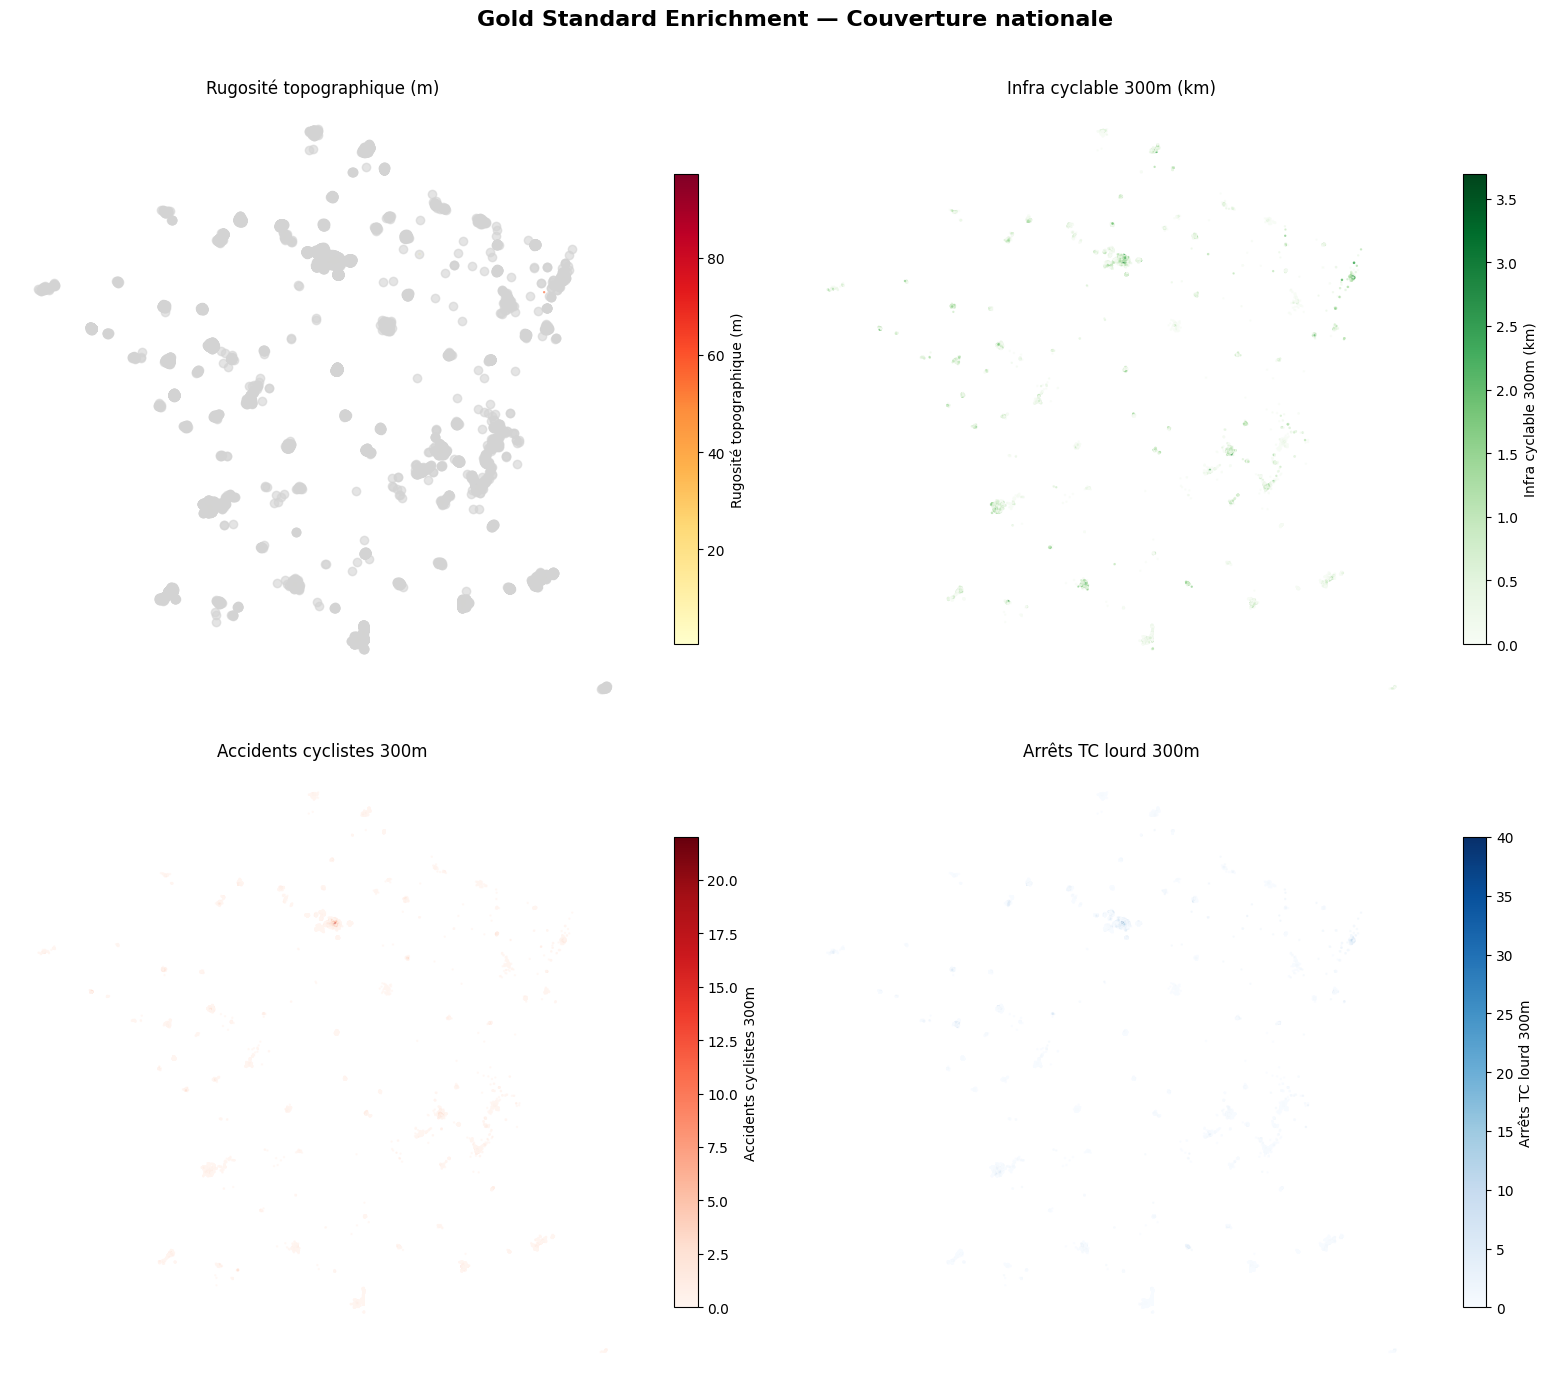

[OK] Figure sauvegardée.


In [44]:
import matplotlib.pyplot as plt

# ── Carte de couverture spatiale des nouvelles variables ──────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle(
    "Gold Standard Enrichment - Couverture nationale",
    fontsize=16, fontweight="bold", y=1.01,
)

gdf_wgs = gdf_proj.to_crs(CRS_GEO)

plot_cfg = [
    ("topography_roughness_index", "Rugosité topographique (m)",  "YlOrRd"),
    ("infra_cyclable_km",          "Infra cyclable 300m (km)",     "Greens"),
    ("baac_accidents_cyclistes",   "Accidents cyclistes 300m",     "Reds"),
    ("gtfs_heavy_stops_300m",      "Arrêts TC lourd 300m",         "Blues"),
]

for ax, (col, title, cmap) in zip(axes.flat, plot_cfg):
    if col in gdf_wgs.columns:
        gdf_wgs.plot(
            ax=ax, column=col, cmap=cmap,
            markersize=0.5, alpha=0.6, legend=True,
            legend_kwds={"shrink": 0.7, "label": title},
            missing_kwds={"color": "lightgrey"},
        )
        ax.set_title(title, fontsize=12)
        ax.axis("off")
    else:
        ax.text(0.5, 0.5, f"{col}\nindisponible",
                ha="center", va="center", transform=ax.transAxes)
        ax.set_title(title)

plt.tight_layout()
fig.savefig(OUTPUT / "figures" / "01_couverture_gold_standard.png",
            dpi=150, bbox_inches="tight")
plt.show()
print("[OK] Figure sauvegardée.")

In [45]:
# ── Export final ──────────────────────────────────────────────────────────────
# Colonnes finales ordonnées
BASE_COLS = [
    "uid", "system_id", "city", "system_name", "source",
    "station_id", "station_name", "lat", "lon", "capacity",
    "has_kiosk", "address", "post_code", "region_id",
    "n_stations_system", "fetched_at",
]
ENRICHED_COLS = [
    "elevation_m",
    "topography_roughness_index",
    "infra_cyclable_km",
    "infra_cyclable_pct",
    "baac_accidents_cyclistes",
    "gtfs_heavy_stops_300m",
    "gtfs_stops_within_300m_pct",
]

available_base    = [c for c in BASE_COLS    if c in gdf_proj.columns]
available_enrich  = [c for c in ENRICHED_COLS if c in gdf_proj.columns]
final_cols        = available_base + available_enrich

df_export = gdf_proj[final_cols].copy()

# Parquet (usage ML / notebooks aval)
out_parquet = OUTPUT / "tables_csv" / "stations_gold_standard.parquet"
df_export.to_parquet(out_parquet, index=False)

# CSV (lisibilité / partage)
out_csv = OUTPUT / "tables_csv" / "stations_gold_standard.csv"
df_export.to_csv(out_csv, index=False, encoding="utf-8-sig")

print(f"[EXPORT] {len(df_export):,} stations exportées.")
print(f"         Parquet : {out_parquet.resolve()}")
print(f"         CSV     : {out_csv.resolve()}")
print(f"         Colonnes: {list(df_export.columns)}")

df_export.head(3)

[EXPORT] 46,312 stations exportées.
         Parquet : C:\Users\Rohan\OneDrive - Cesi\Bureau\CESI\BikeShare-Graph-Forecasting\output\27_Gold_Standard_Enrichment\tables_csv\stations_gold_standard.parquet
         CSV     : C:\Users\Rohan\OneDrive - Cesi\Bureau\CESI\BikeShare-Graph-Forecasting\output\27_Gold_Standard_Enrichment\tables_csv\stations_gold_standard.csv
         Colonnes: ['uid', 'system_id', 'city', 'system_name', 'source', 'station_id', 'station_name', 'lat', 'lon', 'capacity', 'has_kiosk', 'address', 'post_code', 'region_id', 'n_stations_system', 'fetched_at', 'elevation_m', 'topography_roughness_index', 'infra_cyclable_km', 'infra_cyclable_pct', 'baac_accidents_cyclistes', 'gtfs_heavy_stops_300m', 'gtfs_stops_within_300m_pct']


,uid,system_id,city,system_name,source,station_id,station_name,lat,lon,capacity,has_kiosk,address,post_code,region_id,n_stations_system,fetched_at,elevation_m,topography_roughness_index,infra_cyclable_km,infra_cyclable_pct,baac_accidents_cyclistes,gtfs_heavy_stops_300m,gtfs_stops_within_300m_pct
0,auray-quiberon__cqocpihmrgc3lc0gde50,auray-quiberon,Auray,AQTA,MobilityData,cqocpihmrgc3lc0gde50,Gare Auray,47.6798,-3.0010,30.0000,0.0000,NaN,NaN,NaN,11.0000,2026-02-22T08:41:57.686321+00:00,NaN,NaN,0.3848,0.2041,0,2,1.0000
1,auray-quiberon__cqocpitlh8lv2r319lug,auray-quiberon,Auray,AQTA,MobilityData,cqocpitlh8lv2r319lug,Kériolet,47.6676,-2.9840,20.0000,0.0000,NaN,NaN,NaN,11.0000,2026-02-22T08:41:57.686321+00:00,NaN,NaN,0.1621,0.0860,0,0,0.0000
2,auray-quiberon__cqocpitlh8lv2r319m00,auray-quiberon,Auray,AQTA,MobilityData,cqocpitlh8lv2r319m00,Saint-Goustan,47.6668,-2.9797,20.0000,0.0000,NaN,NaN,NaN,11.0000,2026-02-22T08:41:57.686321+00:00,NaN,NaN,0.0000,0.0000,0,0,0.0000


---
## Annexe - Stratégie de montée en charge (46k stations)

| Problème | Solution implémentée |
|----------|---------------------|
| Quota API Open-Elevation | Batch de 200 pts, `ASYNC_CONCURRENCY=10`, reprise sur checkpoint |
| Volume Overpass (cycleways) | 1 requête par ville + cache `.parquet` permanent |
| Téléchargements GTFS lourds | `stream=True` + cache zip → stops.parquet par dataset |
| Jointures spatiales 46k × N | `gpd.sjoin()` vectorisé (R-tree) sur Lambert-93 |
| Interruption / reprise | `checkpoint_save/load()` après chaque module |
| Rate limiting Overpass | `time.sleep(1.0)` entre villes, 0.5s entre zones blanches |

### Alternative haute performance : Open-Elevation self-hosted
```bash
# Docker en local - élimine les quotas et réduit la latence à <1ms/req
docker run -p 8080:8080 ghcr.io/Jorl17/open-elevation
# Puis pointer OPEN_ELEVATION_URL = "http://localhost:8080/api/v1/lookup"
```

### Alternative BAAC via téléchargement direct
```python
# Si les URLs statiques ont changé, utiliser l'API data.gouv.fr :
import requests
r = requests.get('https://www.data.gouv.fr/api/1/datasets/53698f4ca3a729239d2036df/')
resources = r.json()['resources']
# Filtrer par title contenant 'caracteristiques' et l'année souhaitée
```